In [1]:
%matplotlib widget
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import models_vit
# source for PCA code: https://builtin.com/machine-learning/pca-in-python
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#sources for t-SNE code: https://builtin.com/data-science/tsne-python       and  https://www.enjoyalgorithms.com/blog/tsne-algorithm-in-ml
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])


def prepare_model(chkpt_dir, arch='vit_large_patch16'):
    # build model
    model = models_vit.__dict__[arch](
        img_size=224,
        num_classes=2,
        drop_path_rate=0,
        global_pool=True,
    )
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    print(checkpoint["args"])
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    return model

def run_one_image(img, model):

    x = torch.tensor(img)
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    x = x.to(device, non_blocking=True)
    latent = model.forward_features(x.float())
    latent = torch.squeeze(latent)

    return latent


### Load a pre-trained model

In [3]:
# download trained model

chkpt_dir = './finetune_folder/model_85_16/checkpoint-fine.pth'
model_ = prepare_model(chkpt_dir, 'vit_large_patch16')

device = torch.device('cuda')
model_.to(device)
print(chkpt_dir)
print('Model loaded.')


Namespace(aa='rand-m9-mstd0.5-inc1', accum_iter=1, batch_size=16, blr=0.005, clip_grad=None, color_jitter=None, cutmix=0, cutmix_minmax=None, data_path='/scistor/BETA-BPMI-jfdb/jfdbgroup/LungBachelorStudents2024/haitham_data_tiff_224_3/', device='cuda', dist_eval=False, dist_on_itp=False, dist_url='env://', distributed=False, drop_path=0.2, epochs=50, eval=False, finetune='./checkpoints_85_800/checkpoint-1600.pth', global_pool=True, input_size=224, layer_decay=0.65, local_rank=0, log_dir='./finetune_folder/logs/', lr=0.0003125, min_lr=1e-06, mixup=0, mixup_mode='batch', mixup_prob=1.0, mixup_switch_prob=0.5, model='vit_large_patch16', nb_classes=2, num_workers=2, output_dir='./finetune_folder/', pin_mem=True, recount=1, remode='pixel', reprob=0.25, resplit=False, resume='', seed=0, smoothing=0.1, start_epoch=0, task='model_85_16', warmup_epochs=10, weight_decay=0.05, world_size=1)
./finetune_folder/model_85_16/checkpoint-fine.pth
Model loaded.


### Load images and save latent feature

In [4]:
# get image list
data_path = 'PCA_data/'
img_list = os.listdir(data_path)
img_list = sorted(img_list)

name_list = []
feature_list = []
model_.eval()

for i in img_list:
    if i[0] == "T":  # to skip Thumbs file
        continue
    img = Image.open(os.path.join(data_path, i))
    img = img.resize((224, 224))
    img = np.array(img) / 255.

    assert img.shape == (224, 224, 3)

    # normalize by mean and sd
    # can use customised mean and sd for your data
    # img = img - imagenet_mean
    # img = img / imagenet_std

    latent_feature = run_one_image(img, model_)

    name_list.append(i)
    feature_list.append(latent_feature.detach().cpu().numpy())


In [5]:
condition_list  = []
for study in name_list:
    if study[0:3] == "AMI":
        condition_list.append("healthy")
    else:
        condition_list.append("asthma")
latent_csv = pd.DataFrame({'Condition':condition_list, 'Latent_feature':feature_list})

In [6]:
latent_csv

,Condition,Latent_feature
0,asthma,"[-0.07844665, -0.05530723, 0.023762878, -0.363..."
1,asthma,"[-0.026135182, -0.45430183, -0.047674406, -0.3..."
2,asthma,"[-0.028650615, -0.54184544, -0.01767157, -0.30..."
3,asthma,"[-0.115138456, -0.9957578, -0.018650113, -0.04..."
4,asthma,"[-0.035055246, -0.28491846, 0.032248937, -0.38..."
...,...,...
250,asthma,"[-0.11084533, 0.27385756, 0.014765719, -0.3970..."
251,asthma,"[0.01006595, 0.25965446, 0.007683674, -0.34819..."
252,asthma,"[-0.09466545, 0.47677833, -0.0025338978, -0.30..."
253,asthma,"[-0.06526337, 0.46642628, 0.017692158, -0.3332..."


In [7]:
y = latent_csv.loc[:, ["Condition"]].values
x = latent_csv.loc[:, ["Latent_feature"]].values
x = np.array(x)
inner_arrays = [np.array(arr[0]) for arr in x]
x = np.vstack(inner_arrays)
print(x.shape)

(255, 1024)


In [8]:
x_non_standard = x
x = StandardScaler().fit_transform(x)

In [9]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns=["principle component 1", "principle component 2"])
finalDf = pd.concat([principalDf, latent_csv["Condition"]], axis=1)

In [10]:
finalDf

,principle component 1,principle component 2,Condition
0,7.553138,6.631587,asthma
1,-13.668056,-3.069222,asthma
2,-16.330843,-1.814766,asthma
3,-35.742210,-14.753295,asthma
4,-7.113395,4.347418,asthma
...,...,...,...
250,21.392656,4.162407,asthma
251,15.856931,4.251015,asthma
252,22.615253,-0.751643,asthma
253,20.790529,-3.363329,asthma


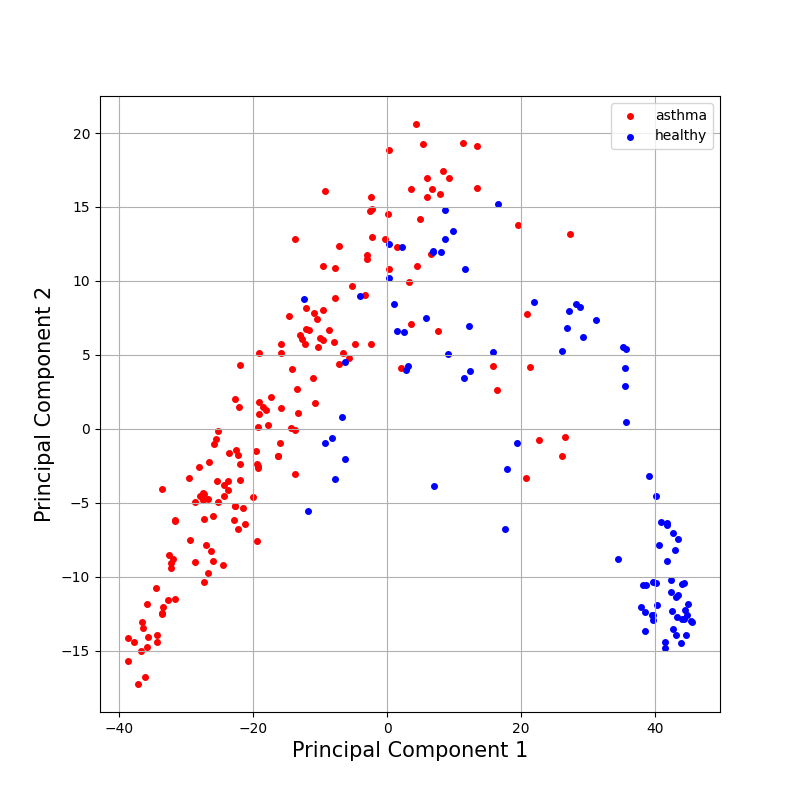

In [11]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
# ax.set_title('2 component PCA', fontsize = 20)

targets = ['asthma', 'healthy']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Condition'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principle component 1']
               , finalDf.loc[indicesToKeep, 'principle component 2']
               , c = color
               , s = 16)
ax.legend(targets)
# ax.set_ylim(-15, 35)
# ax.set_xlim(-50, 66)
ax.grid()

In [12]:
pca_3d = PCA(n_components=3)
principalComponents_3d = pca_3d.fit_transform(x)
principalDf_3d = pd.DataFrame(data = principalComponents_3d, columns=["principle component 1", "principle component 2", "principle component 3"])
finalDf_3d = pd.concat([principalDf_3d, latent_csv["Condition"]], axis=1)

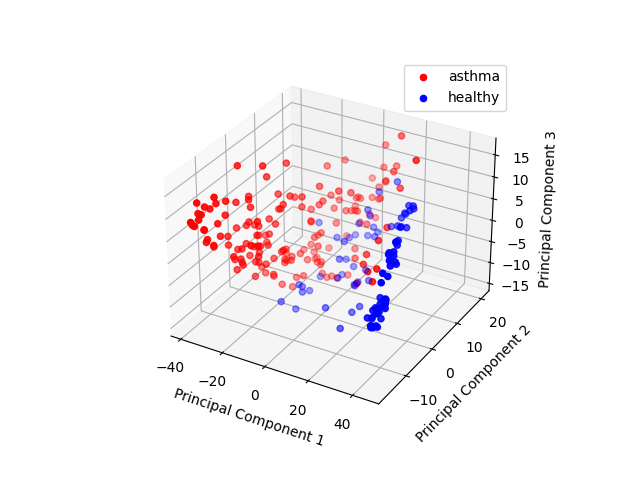

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# ax = Axes3D(fig)
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 2', fontsize = 10)
ax.set_zlabel('Principal Component 3', fontsize = 10)
# ax.set_title('2 component PCA', fontsize = 20)

targets = ['asthma', 'healthy']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Condition'] == target
    ax.scatter(finalDf_3d.loc[indicesToKeep, 'principle component 1']
               , finalDf_3d.loc[indicesToKeep, 'principle component 2']
               , finalDf_3d.loc[indicesToKeep, 'principle component 3']
               , c = color)
ax.legend(targets)
# ax.set_ylim(-15, 35)
# ax.set_xlim(-50, 66)
ax.grid()

In [14]:
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components, random_state=28)
tsne_result = tsne.fit_transform(x)
tsne_result.shape

(255, 2)

<bound method Axes.legend of <AxesSubplot:xlabel='tsne_1', ylabel='tsne_2'>>

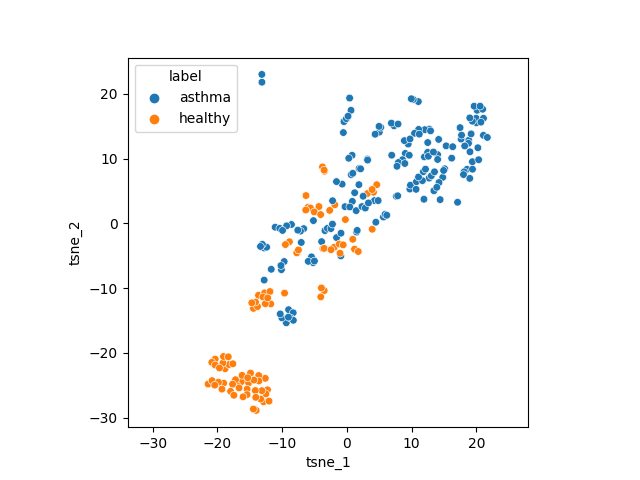

In [15]:
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': finalDf['Condition']})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=30)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
# ax.set_ylim(lim)
ax.set_aspect('equal')
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
ax.legend

In [16]:
n_components = 3
tsne_3d = TSNE(n_components, random_state=0)
tsne_3d_result = tsne_3d.fit_transform(x)
tsne_3d_result.shape

(255, 3)

In [17]:
tsne_result_df_3d = pd.DataFrame({'tsne_1': tsne_3d_result[:,0], 'tsne_2': tsne_3d_result[:,1], 'tsne_3': tsne_3d_result[:,2],'label': finalDf['Condition']})
tsne_result_df_3d

,tsne_1,tsne_2,tsne_3,label
0,-17.828472,-32.409054,11.787189,asthma
1,6.987356,29.595676,32.459858,asthma
2,142.264908,33.273651,-13.371648,asthma
3,32.670895,-50.178444,141.610413,asthma
4,-16.518869,13.962464,12.363199,asthma
...,...,...,...,...
250,61.336472,40.080250,-113.002701,asthma
251,11.024258,-45.364681,-14.117507,asthma
252,15.996880,-68.509308,6.636520,asthma
253,-11.655708,-74.850456,-1.069488,asthma


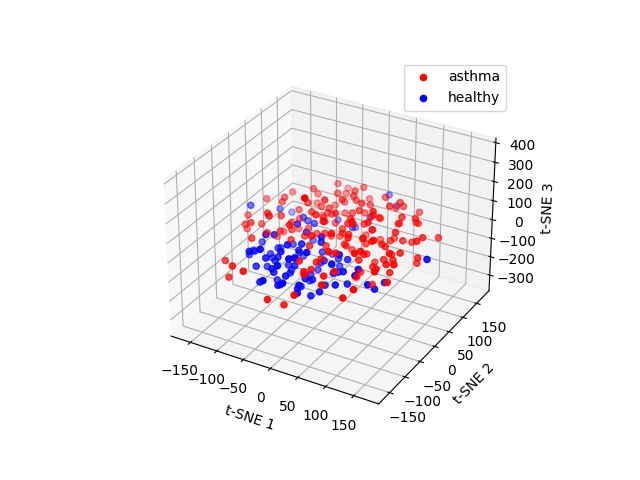

In [18]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel("t-SNE 1", fontsize=10)
ax.set_ylabel("t-SNE 2", fontsize=10)
ax.set_zlabel("t-SNE 3", fontsize=10)

targets = ['asthma', 'healthy']
colors = ['r', 'b']

for target, color in zip(targets, colors):
    indicesToKeep = tsne_result_df_3d["label"] == target
    # print(indicesToKeep)
    ax.scatter(tsne_result_df_3d.loc[indicesToKeep, "tsne_1"], tsne_result_df_3d.loc[indicesToKeep, "tsne_2"], tsne_result_df_3d.loc[indicesToKeep, "tsne_3"], c=color)

ax.legend(targets)
ax.grid()